# Camera Detection Experiments
## Green Tape & Checkerboard Detection for Wind Speed Estimation

This notebook experiments with detecting:
- Green tape marker on the hanging pole
- 5x8 checkerboard pattern (34mm squares) in the background

## 1. Setup and Imports

In [3]:
import numpy as np
import cv2
from picamera2 import Picamera2
import time
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage, clear_output

# For better visualization in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## 2. Camera Initialization

In [4]:
# Initialize camera
picam2 = Picamera2()

# Configure for preview (adjust resolution as needed)
config = picam2.create_preview_configuration(
    main={"format": "RGB888", "size": (1280, 720)}
)

picam2.configure(config)
picam2.start()

# Warm-up time for auto-exposure and white balance
time.sleep(0.5)

print("Camera initialized successfully!")
print(f"Resolution: {config['main']['size']}")

[1:05:09.617312069] [6907]  INFO Camera camera_manager.cpp:330 libcamera v0.5.2+99-bfd68f78
[1:05:09.625722511] [6932]  INFO RPI pisp.cpp:720 libpisp version 1.3.0
[1:05:09.628702726] [6932]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/pisp/imx477.json
[1:05:09.636536391] [6932]  INFO Camera camera_manager.cpp:220 Adding camera '/base/axi/pcie@1000120000/rp1/i2c@88000/imx477@1a' for pipeline handler rpi/pisp
[1:05:09.636555576] [6932]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@88000/imx477@1a to CFE device /dev/media2 and ISP device /dev/media1 using PiSP variant BCM2712_C0
[1:05:09.643934701] [6907]  INFO Camera camera.cpp:1215 configuring streams: (0) 1280x720-RGB888/sRGB (1) 2028x1080-BGGR_PISP_COMP1/RAW
[1:05:09.644065196] [6932]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@88000/imx477@1a - Selected sensor format: 2028x1080-SBGGR12_1X12/RAW - Selected CFE format: 2028x1080-PC1B/RAW


Camera initialized successfully!
Resolution: (1280, 720)


## 3. Capture and Display a Test Frame

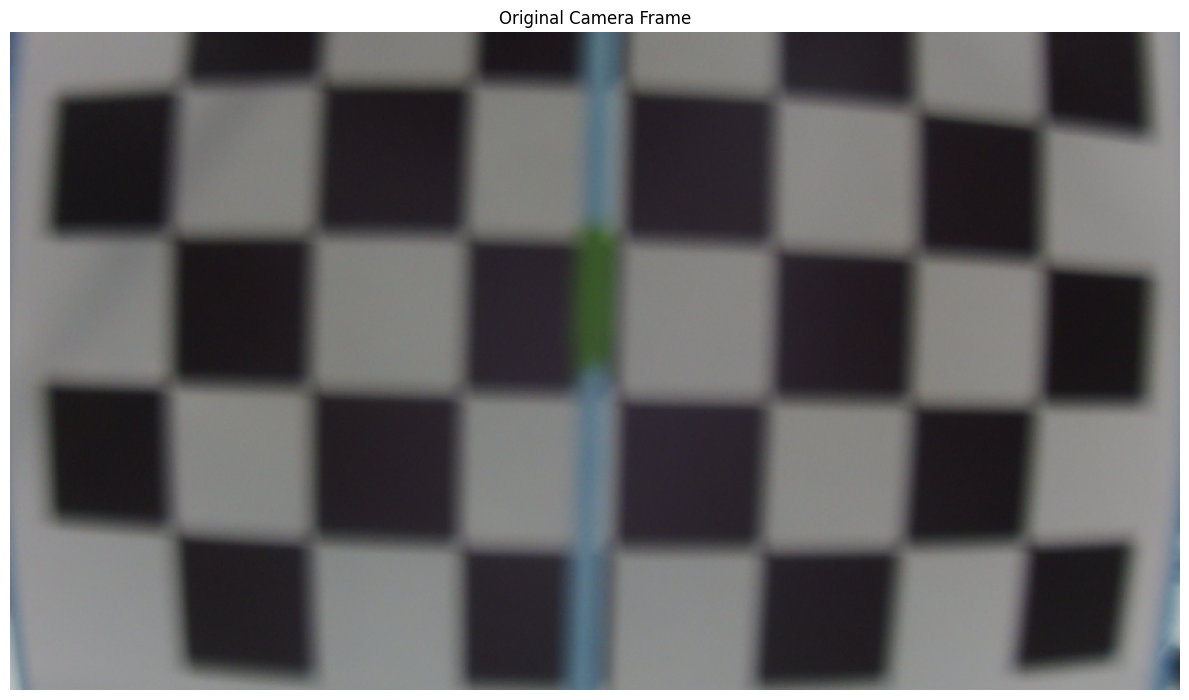

Frame shape: (720, 1280, 3)
Frame dtype: uint8


In [5]:
# Capture a frame
frame = picam2.capture_array()

# Display
plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.title("Original Camera Frame")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Frame shape: {frame.shape}")
print(f"Frame dtype: {frame.dtype}")

## 4. Green Tape Detection - HSV Color Space

We'll convert to HSV and experiment with thresholds to isolate the green tape.

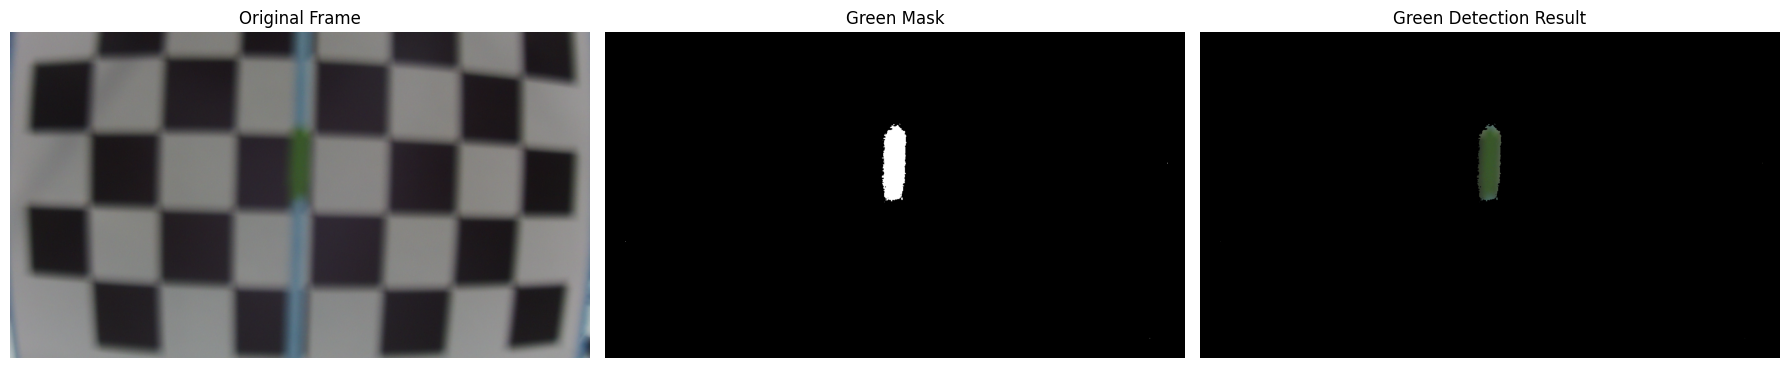

HSV Lower bound: [35 50 50]
HSV Upper bound: [ 85 255 255]


In [6]:
# Convert to HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

# Initial green HSV range (adjust these based on your tape color)
# For indoor lighting with typical green tape:
lower_green = np.array([35, 50, 50])   # H, S, V lower bounds
upper_green = np.array([85, 255, 255])  # H, S, V upper bounds

# Create mask
mask_green = cv2.inRange(hsv, lower_green, upper_green)

# Apply mask to original image
green_detected = cv2.bitwise_and(frame, frame, mask=mask_green)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(frame)
axes[0].set_title("Original Frame")
axes[0].axis('off')

axes[1].imshow(mask_green, cmap='gray')
axes[1].set_title("Green Mask")
axes[1].axis('off')

axes[2].imshow(green_detected)
axes[2].set_title("Green Detection Result")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"HSV Lower bound: {lower_green}")
print(f"HSV Upper bound: {upper_green}")

## 5. Fine-tune HSV Thresholds

Adjust these values to better isolate the green tape:

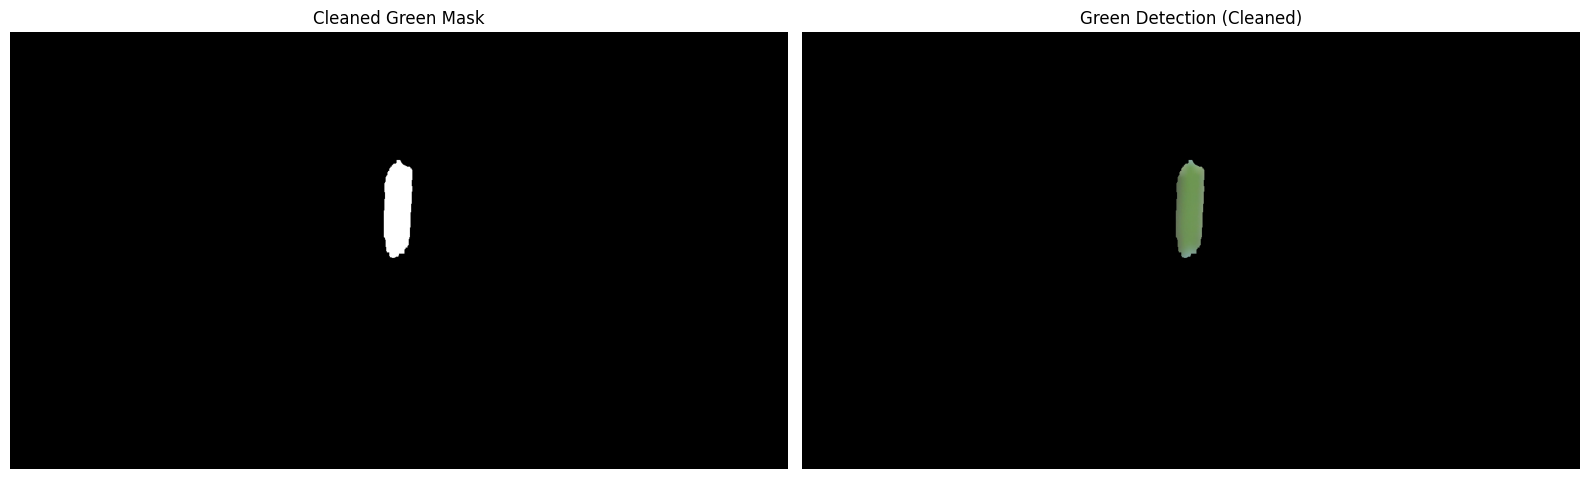

In [7]:
# Adjust these values based on the previous result
H_min, S_min, V_min = 35, 50, 50
H_max, S_max, V_max = 85, 255, 255

lower_green = np.array([H_min, S_min, V_min])
upper_green = np.array([H_max, S_max, V_max])

# Recapture and apply
frame = picam2.capture_array()
hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
mask_green = cv2.inRange(hsv, lower_green, upper_green)

# Clean up mask with morphological operations
kernel = np.ones((5, 5), np.uint8)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)

green_detected = cv2.bitwise_and(frame, frame, mask=mask_green)

# Display
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(mask_green, cmap='gray')
axes[0].set_title("Cleaned Green Mask")
axes[0].axis('off')

axes[1].imshow(green_detected)
axes[1].set_title("Green Detection (Cleaned)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 6. Find Green Tape Contours and Centroid

Found 1 valid green contours
Contour 0: Centroid=(637, 291), Area=6029.5


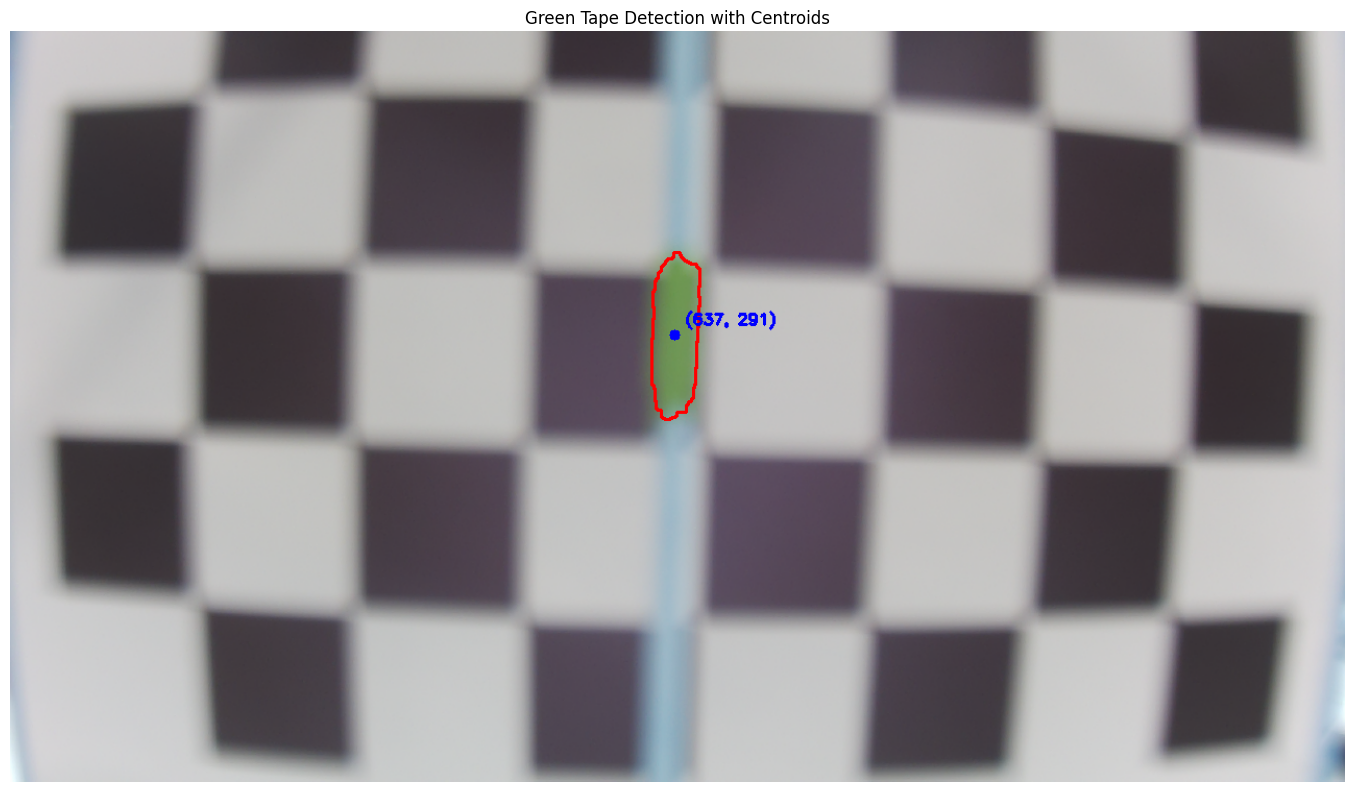

In [8]:
# Find contours
contours, hierarchy = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter by area to remove noise
min_area = 100  # Adjust based on your setup
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

print(f"Found {len(valid_contours)} valid green contours")

# Draw contours and centroids
frame_with_contours = frame.copy()

for i, cnt in enumerate(valid_contours):
    # Draw contour
    cv2.drawContours(frame_with_contours, [cnt], -1, (255, 0, 0), 2)
    
    # Calculate centroid
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        # Draw centroid
        cv2.circle(frame_with_contours, (cx, cy), 5, (0, 0, 255), -1)
        cv2.putText(frame_with_contours, f"({cx}, {cy})", (cx + 10, cy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        area = cv2.contourArea(cnt)
        print(f"Contour {i}: Centroid=({cx}, {cy}), Area={area:.1f}")

# Display
plt.figure(figsize=(14, 8))
plt.imshow(frame_with_contours)
plt.title("Green Tape Detection with Centroids")
plt.axis('off')
plt.tight_layout()
plt.show()

## 7. Checkerboard Detection

Detect the 5x8 checkerboard pattern (34mm squares)

✗ Checkerboard not detected. Try adjusting camera angle or lighting.


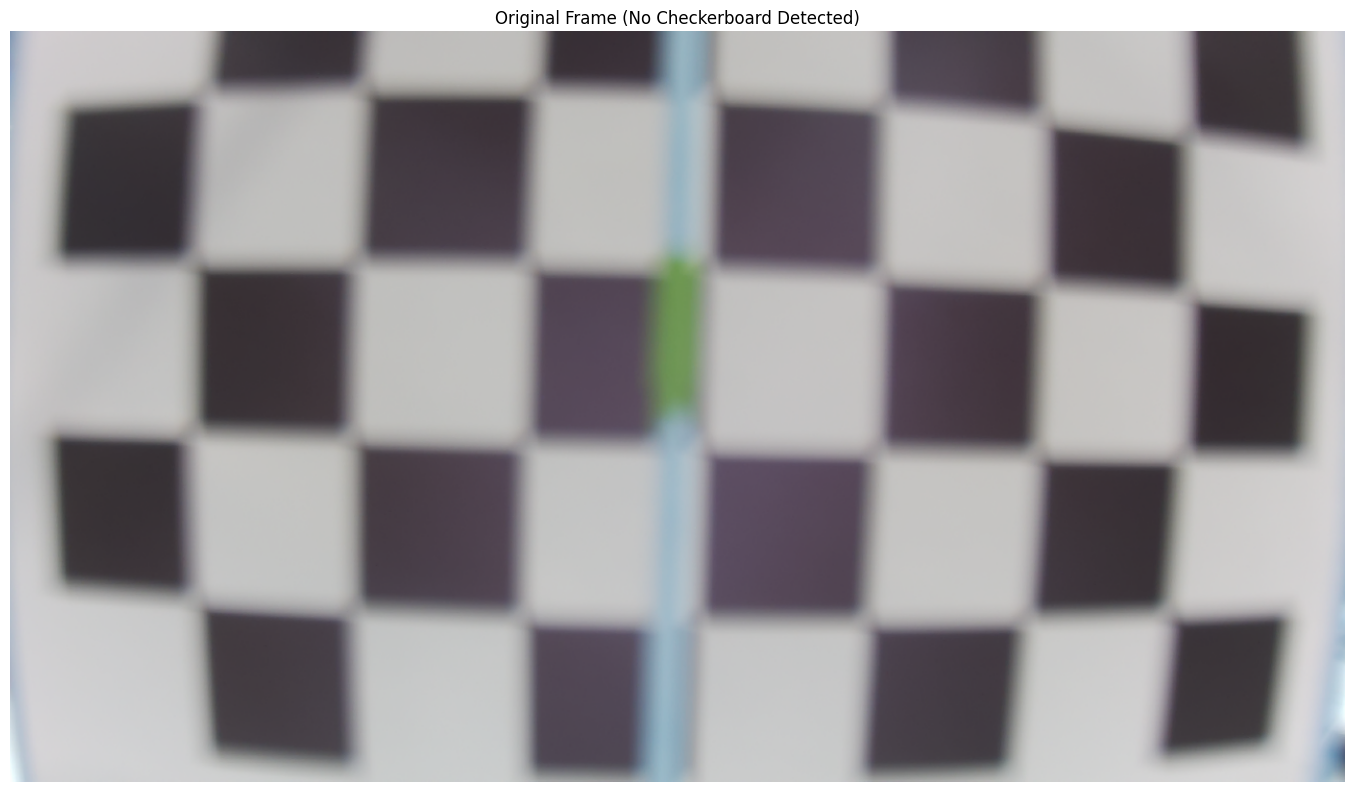

In [9]:
# Checkerboard dimensions (interior corners)
# For a 5x8 checkerboard, the interior corners are (5-1) x (8-1) = 4x7
checkerboard_size = (4, 7)

# Capture fresh frame
frame = picam2.capture_array()
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

# Find checkerboard corners
ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

if ret:
    print(f"✓ Checkerboard detected! Found {len(corners)} corners")
    
    # Refine corner positions for sub-pixel accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners_refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    
    # Draw corners on frame
    frame_with_checkerboard = frame.copy()
    cv2.drawChessboardCorners(frame_with_checkerboard, checkerboard_size, corners_refined, ret)
    
    # Display
    plt.figure(figsize=(14, 8))
    plt.imshow(frame_with_checkerboard)
    plt.title("Checkerboard Detection (4x7 interior corners)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
else:
    print("✗ Checkerboard not detected. Try adjusting camera angle or lighting.")
    plt.figure(figsize=(14, 8))
    plt.imshow(frame)
    plt.title("Original Frame (No Checkerboard Detected)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 8. Combined Detection: Green Tape + Checkerboard

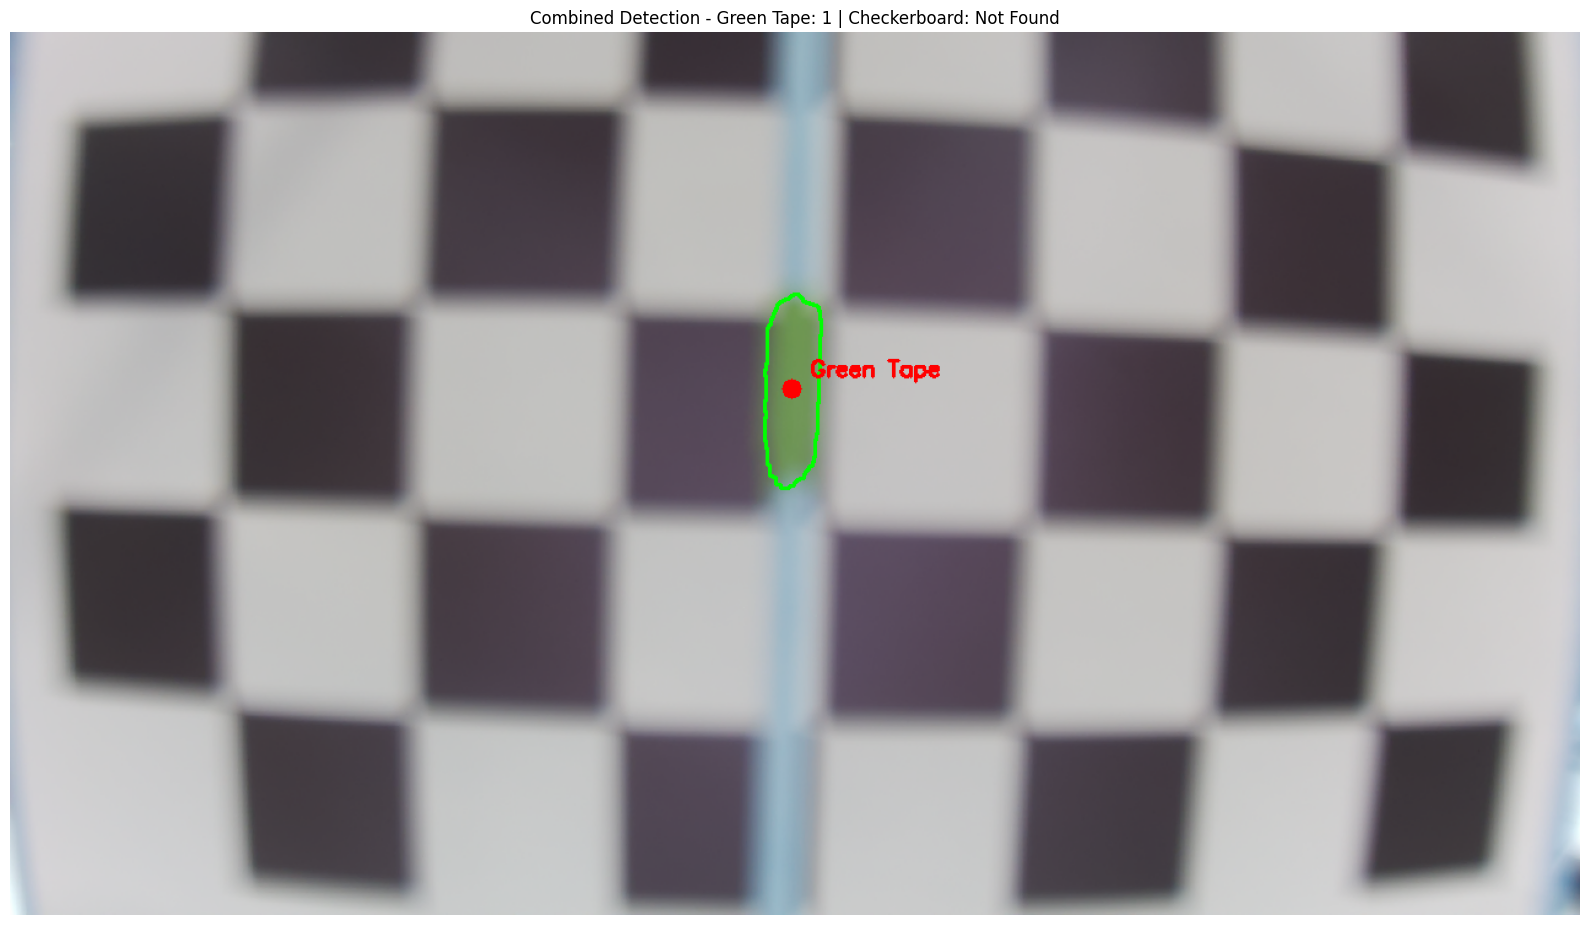


=== Detection Summary ===
Green tape centroids: [(637, 291)]
Checkerboard detected: False


: 

In [ ]:
# Capture fresh frame
frame = picam2.capture_array()
frame_combined = frame.copy()

# --- Green Tape Detection ---
hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
mask_green = cv2.inRange(hsv, lower_green, upper_green)

# Clean mask
kernel = np.ones((5, 5), np.uint8)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)

# Find green contours
contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Draw green tape detection
green_centroids = []
for cnt in valid_contours:
    cv2.drawContours(frame_combined, [cnt], -1, (0, 255, 0), 2)
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        green_centroids.append((cx, cy))
        cv2.circle(frame_combined, (cx, cy), 8, (255, 0, 0), -1)
        cv2.putText(frame_combined, "Green Tape", (cx + 15, cy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# --- Checkerboard Detection ---
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

if ret:
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners_refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    cv2.drawChessboardCorners(frame_combined, checkerboard_size, corners_refined, ret)

# Display combined result
plt.figure(figsize=(16, 10))
plt.imshow(frame_combined)
plt.title(f"Combined Detection - Green Tape: {len(green_centroids)} | Checkerboard: {'Found' if ret else 'Not Found'}")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n=== Detection Summary ===")
print(f"Green tape centroids: {green_centroids}")
print(f"Checkerboard detected: {ret}")
if ret:
    print(f"Checkerboard corners: {len(corners)} detected")

## 9. Live Preview Loop (Optional)

Run this cell to see live detections. Press 'q' in the OpenCV window to stop.

## 9. Live Video Feed in Notebook

This cell displays live camera feed directly in the notebook with real-time detection. Stop by interrupting the cell (press the stop button).

from IPython.display import display, Image
import ipywidgets as widgets

# Create output widget for live display
output = widgets.Output()
display(output)

print("Starting live feed in notebook. Press the stop button (■) to interrupt.")

try:
    frame_count = 0
    while True:
        # Capture frame
        frame = picam2.capture_array()
        display_frame = frame.copy()
        
        # Green detection
        hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        kernel = np.ones((5, 5), np.uint8)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
        
        contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
        
        # Draw green tape detection
        for cnt in valid_contours:
            cv2.drawContours(display_frame, [cnt], -1, (0, 255, 0), 2)
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.circle(display_frame, (cx, cy), 8, (255, 0, 0), -1)
                cv2.putText(display_frame, f"({cx},{cy})", (cx + 10, cy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        
        # Checkerboard detection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
        if ret:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners_refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            cv2.drawChessboardCorners(display_frame, checkerboard_size, corners_refined, ret)
        
        # Add info text
        info_text = f"Green: {len(valid_contours)} | Checkerboard: {'Yes' if ret else 'No'} | Frame: {frame_count}"
        cv2.putText(display_frame, info_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Encode frame to JPEG for display
        _, encoded = cv2.imencode('.jpg', cv2.cvtColor(display_frame, cv2.COLOR_RGB2BGR))
        
        # Display in notebook
        with output:
            clear_output(wait=True)
            display(Image(data=encoded.tobytes()))
        
        frame_count += 1
        time.sleep(0.033)  # ~30 FPS
        
except KeyboardInterrupt:
    print("Live feed stopped by user")
finally:
    print(f"Total frames displayed: {frame_count}")

In [ ]:
print("Starting live preview. Press 'q' in the OpenCV window to stop.")

try:
    while True:
        # Capture frame
        frame = picam2.capture_array()
        display_frame = frame.copy()
        
        # Green detection
        hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        kernel = np.ones((5, 5), np.uint8)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
        
        contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
        
        for cnt in valid_contours:
            cv2.drawContours(display_frame, [cnt], -1, (0, 255, 0), 2)
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.circle(display_frame, (cx, cy), 8, (255, 0, 0), -1)
        
        # Checkerboard detection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
        if ret:
            cv2.drawChessboardCorners(display_frame, checkerboard_size, corners, ret)
        
        # Convert RGB to BGR for OpenCV display
        display_frame_bgr = cv2.cvtColor(display_frame, cv2.COLOR_RGB2BGR)
        
        # Show frame
        cv2.imshow("Live Detection", display_frame_bgr)
        
        # Exit on 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
except KeyboardInterrupt:
    print("Interrupted by user")
finally:
    cv2.destroyAllWindows()
    print("Live preview stopped.")

Starting live preview. Press 'q' in the OpenCV window to stop.


## 10. Save Current HSV Settings

In [ ]:
import json

# Save HSV thresholds for later use
config_data = {
    "hsv_lower_green": lower_green.tolist(),
    "hsv_upper_green": upper_green.tolist(),
    "checkerboard_size": checkerboard_size,
    "checkerboard_square_mm": 34,
    "min_contour_area": min_area
}

with open('detection_config.json', 'w') as f:
    json.dump(config_data, f, indent=2)

print("Configuration saved to detection_config.json")
print(json.dumps(config_data, indent=2))

## 11. Cleanup

In [ ]:
# Stop camera
picam2.stop()
cv2.destroyAllWindows()
print("Camera stopped and windows closed.")